In [0]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from os import listdir
import random
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import random

import xml.etree.ElementTree as ET
import numpy as np
from scipy import misc
from PIL import Image
import glob
import imageio
import os

import matplotlib.pyplot as plt

from google.colab import files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class YOLO(nn.Module):
    """neural network architectur inspired by YOLO V1"""
    
    def __init__(self, col_size):
        super(YOLO, self).__init__()
        self.col_size = col_size
        self.conv1 = nn.Conv2d(1, 16, 7, stride=2)
        self.mp1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), stride=1)
        self.mp2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, (3, 3), stride=1)
        self.mp3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*5*104, 2048)
        self.fc2 = nn.Linear(2048, col_size * 3)
        self.dropout = nn.Dropout()

    def forward(self, x):
        # Conv + ReLU + max pooling for two layers
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = self.mp1(x)
        #print(x.size())
        x = F.relu(self.conv2(x))
        #print(x.size())
        x = self.mp2(x)
        #print(x.size())
        x = F.relu(self.conv3(x))
        #print(x.size())
        x = self.mp3(x)
        #print(x.size())
        x = x.view(-1, 64*5*104)
        #print(x.size())
        x = F.relu(self.dropout(self.fc1(x)))
        #print(x.size())
        x = self.fc2(x)
        #print(x.size())
        x = x.view(-1, self.col_size, 3)
        #print(x.size())
        x = torch.sigmoid(x)
        return x

In [0]:
def create_data(col_size, batch_size, transform, imgs_path, xmls_path, train_bool):
    """create data for training/validation from img and xml to tensor"""
    
    data_list = []
    target_list = []
    data = []

    imgs = os.listdir(imgs_path)
    imgs.sort()
    xmls = os.listdir(xmls_path)
    xmls.sort()

    for i in range(len(imgs)):
        
        img = Image.open(imgs_path + imgs[i])

        old_width = img.size[0]

        img_tensor = transform(img)
        data_list.append((img_tensor))
        
        col_width = img_tensor.size(2) / col_size

        width_factor = img_tensor.size(2) / old_width

        tree = ET.parse(xmls_path + xmls[i]) 
        root = tree.getroot()

        target = [[0, 0, 0] for i in range(col_size)]

        for word in root:  # root[1] catches handwritten part
            x1 = int(word.attrib["x"]) * width_factor
            width = int(word.attrib["width"]) * width_factor 
            if(int(word.attrib["x"]) > old_width):
                print(int(word.attrib["x"]), old_width)
                print(imgs[i], xmls[i])
                continue

            col = int(x1 // col_width)
            
            b_box = [1, (x1 % col_width) / col_width, width / img_tensor.size(2)] 
            #print(b_box)
            if(col < 0 or col >= 30):
                print("col", col)
                continue
                print(imgs[i], xmls[i])
            target[col] = b_box

        del(root)
        del(tree)
        del(img)
        del(img_tensor)
        target = torch.FloatTensor(target)
        target_list.append(target)
        del(target)
        if len(data_list) >= batch_size:
            data.append((torch.stack(data_list), torch.stack(target_list)))
            del(data_list)
            del(target_list)
            data_list = []
            target_list = []

            print('Loaded batch ', len(data), 'of ', int(len(listdir(imgs_path)) / batch_size))
            print('Percentage Done: ',
                  100 * (len(data)) / int(len(listdir(imgs_path)) / batch_size), '%')

    return data

In [0]:
def train(train_data, model, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_data (torch tensor): The trainset
        model (torch.nn.module): Model to be trained
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    # switch to train mode
    model.train()

    # iterate through the dataset loader
    i = 0
    losses = []
    ious = []
    for (inp, target) in train_data:
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = target.to(device)

        # compute output, i.e. the model forward
        output = model(inp)

        # print("output", output.size(), "target", target.size())
        # calculate the loss

        loss = yolo_loss(output, target)
        #print("loss", loss)
        if (i == 0):
            print(output[0])
            print(target[0])
        i += 1
        iou = calc_mean_iou(output, target)
        print("loss {:.2} IOU {:.2}".format(loss,iou))
        ious.append(iou)

        # compute gradient and do the SGD step
        # we reset the optimizer with zero_grad to "flush" former gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def validate(val_dataset, model, device, threshold, percent):
    model.eval()

    # avoid computation of gradients and necessary storing of intermediate layer activations
    with torch.no_grad():
        # iterate through the dataset loader
        losses = []
        ious = []
        accs = []
        precs = []
        recs = []

        for (inp, target) in val_dataset:
            # transfer to device
            inp = inp.to(device)
            target = target.to(device)

            # compute output
            output = model(inp)

            #find right boxes
            non_maximum_suppression(output, percent)

            # compute loss
            loss = yolo_loss(output, target)
            iou = calc_mean_iou(output, target)
            acc = calc_accuracy(output, target, threshold)
            prec = calc_precision(output, target, threshold)
            rec = calc_recall(output, target, threshold) 

            losses.append(loss)
            ious.append(iou)
            accs.append(acc)
            precs.append(prec)
            recs.append(rec)

            print("loss {:.2} IOU {:.2}".format(loss,iou))
            #print("IOU", iou)
    avg_loss = torch.mean(torch.stack(losses)).item()
    avg_iou = torch.mean(torch.stack(ious)).item()
    avg_acc = sum(accs) / len(accs)
    avg_prec = sum(precs) / len(precs)
    avg_rec = sum(recs) / len(recs)
    #print("avg. loss", torch.mean(torch.stack(losses)))
    #print("avg. IOU", torch.mean(torch.stack(ious)))
    print("avg. loss {:.2} avg. IOU {:.2} avg. acc {:.2} avg. prec {:.2} avg. rec {:.2}".format(avg_loss, avg_iou, avg_acc, avg_prec, avg_rec))

    return [avg_loss, avg_iou, avg_acc, avg_prec, avg_rec]

In [0]:
def yolo_loss(output, target):
    """calculate loss from output with target"""
    
    lambda_coord = 5
    lambda_noob = 0.5
    errors = []
    for i in range(output.size(0)):
        error1 = 0
        error2 = 0
        error3 = 0
        error4 = 0
        for j in range(output.size(1)):
            if (target[i][j][0] == 1.0):
                #print(target[i][j][1])
                #print(target[1])
                error1 += (target[i][j][1] - output[i][j][1]) ** 2
                error2 += ((target[i][j][2]).sqrt() - (output[i][j][2]).sqrt()) ** 2
                error3 += (target[i][j][0] - output[i][j][0]) ** 2
            else: 
                error4 += (target[i][j][0] - output[i][j][0]) ** 2
        error = lambda_coord * error1 + lambda_coord * error2 + error3 + lambda_noob * error4
        errors.append(error)
    return torch.mean(torch.stack(errors))

In [0]:
def calc_iou(box1, box2):
    """calculate iou for 2 boxes"""
    
    # calculate the coordinates of the insersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # calculate the area of intersetion rectangle
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # calculate the area of the single boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = intersection / (box1_area + box2_area - intersection)

    return iou


In [0]:
def calc_x_y(col, tensor):
    """calculate x, y, width, height from output """
    
    x = tensor[1] * (1700 / 30) + col * (1700 / 30)
    width = tensor[2] * 1700
    return torch.FloatTensor([1, x, 0, width, 120])

In [0]:
def calc_mean_iou(output, target):
    """calculate iou for batch"""
    
    iou_list = []
    for i in range(output.size(0)):
        ious = []
        for j in range(output.size(1)):
            if (target[i][j][0] == 1):
                x_y_target = calc_x_y(j, target[i, j])
                x_y_output = calc_x_y(j, output[i, j])
                box1 = calc_box(x_y_target)
                box2 = calc_box(x_y_output)
                ious.append(calc_iou(box1, box2))
        iou_list.append(torch.mean(torch.stack(ious)))

    mean_iou = torch.mean(torch.stack(iou_list))
    return mean_iou

In [0]:
def calc_box(tensor):
    """calculate coordinates for the output image from tensor"""
    
    x1 = tensor[1]
    y1 = tensor[2]
    x2 = min(1700, x1 + tensor[3])
    y2 = min(120, y1 + tensor[4])
    box = [x1, y1, x2, y2]

    return box

In [0]:
def calc_accuracy(output, target, percent):
    """calculate accuracy for a batch, by percent as treshold"""
    acc_list = []
    for i in range(output.size(0)):
        for j in range(output.size(1)):
            if (target[i][j][0] == 1):
                acc_list.append(1 if (output[i][j][0] >= percent) else 0)
            else:
                acc_list.append(1 if (output[i][j][0] < percent) else 0)
    acc = sum(acc_list) / len(acc_list) if(sum(acc_list) > 0) else 0 
    return acc 

In [0]:
def calc_precision(output, target, percent):
    """calculate precision for a batch, by percent as treshold"""
    
    prec_list = []
    for i in range(output.size(0)):
        for j in range(output.size(1)):
            if (output[i][j][0] >= percent):
                prec_list.append(1 if (target[i][j][0] == 1) else 0)
    prec = sum(prec_list) / len(prec_list) if(sum(prec_list) > 0) else 0     
    return sum(prec_list) / len(prec_list)

In [0]:
def calc_recall(output, target, percent):
    """calculate recall for a batch, by percent as treshold"""
    
    rec_list = []
    for i in range(output.size(0)):
        for j in range(output.size(1)):
            if (target[i][j][0] == 1):
                rec_list.append(1 if (output[i][j][0] >= percent) else 0)
    
    rec = sum(rec_list) / len(rec_list) if(sum(rec_list) > 0) else 0 
    return rec

In [0]:
def non_maximum_suppression(tensor, percent):
    """choose predicted lines by highest propability. 
    Lines who overlap a actual choosen line by percent or higher will delete."""
    
    for i in range(tensor.size(0)):
        for j in range(tensor.size(1)):
            if(tensor[i,j,0].item() < 0.2):
                tensor[i,j,0] = torch.tensor(0)
        found = []
        while(True):
            maximum = 0
            index = 0
            for j in range(tensor.size(1)):
                if(tensor[i,j,0].item() > maximum and j not in found):
                    maximum = tensor[i,j,0].item()
                    index = j

            if(maximum == 0):
                break

            found.append(index)
            tensor[i,index,0] = torch.tensor(1)
            
            for j in range(tensor.size(1)):
                if(j != index and tensor[i,j,0] >= 0.2):
                    x_y_max = calc_x_y(index, tensor[i, index])
                    x_y_other = calc_x_y(j, tensor[i, j])
                    box1 = calc_box(x_y_max)
                    box2 = calc_box(x_y_other)
                    if(calc_iou(box1, box2) > percent):
                        tensor[i,j,0] = 0

In [0]:
imgs_train_path = 'drive/My Drive/data_word_detection/lines_train/'
xmls_train_path = 'drive/My Drive/data_word_detection/xml_lines_train/'
imgs_test_path = 'drive/My Drive/data_word_detection/lines_test/'
xmls_test_path = 'drive/My Drive/data_word_detection/xml_lines_test/'

weight_path = "C:/Users/Pasca/Documents/Goethe-Uni/Master_1.Semester/Pattern_Analyis_Machine_Intelligence/Abschlussprojekt/sentence_detection_small_weights_10/weights"

batch_size = 16
col_size = 30
transform = transforms.Compose([transforms.Resize((120, 1700)),
                                    transforms.ToTensor()])

train_data = create_data(col_size, batch_size, transform, imgs_train_path, xmls_train_path, True)

Loaded batch  1 of  719
Percentage Done:  0.13908205841446453 %
Loaded batch  2 of  719
Percentage Done:  0.27816411682892905 %
Loaded batch  3 of  719
Percentage Done:  0.4172461752433936 %
Loaded batch  4 of  719
Percentage Done:  0.5563282336578581 %
Loaded batch  5 of  719
Percentage Done:  0.6954102920723226 %
Loaded batch  6 of  719
Percentage Done:  0.8344923504867872 %
Loaded batch  7 of  719
Percentage Done:  0.9735744089012517 %
Loaded batch  8 of  719
Percentage Done:  1.1126564673157162 %
Loaded batch  9 of  719
Percentage Done:  1.2517385257301807 %
Loaded batch  10 of  719
Percentage Done:  1.3908205841446453 %
Loaded batch  11 of  719
Percentage Done:  1.5299026425591098 %
Loaded batch  12 of  719
Percentage Done:  1.6689847009735743 %
Loaded batch  13 of  719
Percentage Done:  1.8080667593880388 %
Loaded batch  14 of  719
Percentage Done:  1.9471488178025034 %
Loaded batch  15 of  719
Percentage Done:  2.086230876216968 %
Loaded batch  16 of  719
Percentage Done:  2.225

In [0]:
# set a boolean flag that indicates whether a cuda capable GPU is available
# we will need this for transferring our tensors to the device and
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")

model = YOLO(col_size).to(device)

print(model)
# optimizer
print(model(train_data[0][0].to(device)))
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

test_data = create_data(col_size, batch_size, transform, imgs_test_path, xmls_test_path, True)

GPU is available: True
If you are receiving False, try setting your runtime to GPU
YOLO(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=33280, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=90, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
tensor([[[0.5042, 0.5055, 0.4987],
         [0.5021, 0.4906, 0.4979],
         [0.4907, 0.5020, 0.5009],
         ...,
         [0.4999, 0.4986, 0.5070],
         [0.4964, 0.5057, 0.4997],
         [0.4968, 0.4969, 0.4942]],

        [[0.5091, 0.5004, 0.4911],
         [0.5036, 0.4926, 0.4971],
         

In [0]:
total_epochs = 30
val_list = []
train_list = []
percent_val = 0.5
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train(train_data, model, optimizer, device)
    print("VALIDATION")
    val_list.append(validate(test_data, model, device, percent_val))
    train_list.append(validate(train_data, model, device, percent_val))
    if((epoch + 1) > 10):
        torch.save(model, "/content/drive/My Drive/" + "weights_lines_to_words_" + str(epoch+1) + ".pt")
    for lis in train_list:
        print(lis)
    for lis in val_list:
        print(lis)

Streaming output truncated to the last 5000 lines.
loss 1.1 IOU 0.74
loss 1.2 IOU 0.68
loss 1.2 IOU 0.69
loss 0.93 IOU 0.7
loss 0.97 IOU 0.7
loss 0.96 IOU 0.76
loss 1.2 IOU 0.7
loss 0.8 IOU 0.75
loss 1.2 IOU 0.69
loss 0.91 IOU 0.71
loss 1.3 IOU 0.73
loss 1.2 IOU 0.72
loss 0.76 IOU 0.74
loss 1.2 IOU 0.72
loss 0.98 IOU 0.73
loss 1.0 IOU 0.72
loss 0.94 IOU 0.71
loss 0.91 IOU 0.7
loss 1.2 IOU 0.72
loss 1.3 IOU 0.7
loss 0.94 IOU 0.73
loss 0.84 IOU 0.72
loss 1.1 IOU 0.74
loss 0.88 IOU 0.71
loss 0.93 IOU 0.72
loss 0.9 IOU 0.73
loss 1.0 IOU 0.7
loss 1.2 IOU 0.71
loss 1.0 IOU 0.72
loss 0.99 IOU 0.74
loss 0.79 IOU 0.75
loss 0.86 IOU 0.73
loss 0.86 IOU 0.71
loss 1.1 IOU 0.72
loss 0.75 IOU 0.73
loss 0.99 IOU 0.67
loss 0.8 IOU 0.71
loss 1.3 IOU 0.69
loss 1.2 IOU 0.72
loss 0.9 IOU 0.7
loss 0.99 IOU 0.67
loss 0.99 IOU 0.72
loss 0.88 IOU 0.73
loss 1.2 IOU 0.7
loss 1.5 IOU 0.74
loss 1.3 IOU 0.71
loss 1.1 IOU 0.74
loss 1.4 IOU 0.68
loss 1.1 IOU 0.74
loss 1.1 IOU 0.74
loss 1.4 IOU 0.71
loss 1.3 IOU 0.72


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type YOLO. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Streaming output truncated to the last 5000 lines.
loss 0.55 IOU 0.73
loss 0.47 IOU 0.77
loss 0.49 IOU 0.74
loss 0.39 IOU 0.76
loss 0.41 IOU 0.74
loss 0.54 IOU 0.73
loss 0.64 IOU 0.73
loss 0.43 IOU 0.75
loss 0.35 IOU 0.75
loss 0.32 IOU 0.75
loss 0.43 IOU 0.78
loss 0.5 IOU 0.75
loss 0.48 IOU 0.75
loss 0.46 IOU 0.74
loss 0.27 IOU 0.75
loss 0.45 IOU 0.71
loss 0.45 IOU 0.72
loss 0.37 IOU 0.73
loss 0.47 IOU 0.72
loss 0.47 IOU 0.78
loss 0.53 IOU 0.75
loss 0.43 IOU 0.71
loss 0.57 IOU 0.7
loss 0.46 IOU 0.73
loss 0.47 IOU 0.74
loss 0.39 IOU 0.74
loss 0.46 IOU 0.77
loss 0.5 IOU 0.74
loss 0.49 IOU 0.77
loss 0.37 IOU 0.75
loss 0.52 IOU 0.73
loss 0.83 IOU 0.74
loss 0.62 IOU 0.72
loss 0.56 IOU 0.71
loss 0.62 IOU 0.74
loss 0.44 IOU 0.77
loss 0.32 IOU 0.74
loss 0.41 IOU 0.74
loss 0.51 IOU 0.7
loss 0.45 IOU 0.74
loss 0.48 IOU 0.73
loss 0.27 IOU 0.79
loss 0.29 IOU 0.77
loss 0.55 IOU 0.73
loss 0.43 IOU 0.77
loss 0.41 IOU 0.72
loss 0.43 IOU 0.73
loss 0.32 IOU 0.8
loss 0.3 IOU 0.77
loss 0.37 IOU 0.78
loss 

In [0]:
train_loss = [lis[0] for lis in train_list]
train_iou = [lis[1] for lis in train_list]
train_acc = [lis[2] for lis in train_list]
train_prec = [lis[3] for lis in train_list]
train_rec = [lis[4] for lis in train_list]

In [0]:
val_loss = [lis[0] for lis in val_list]
val_iou = [lis[1] for lis in val_list]
val_acc = [lis[2] for lis in val_list]
val_prec = [lis[3] for lis in val_list]
val_rec = [lis[4] for lis in val_list]

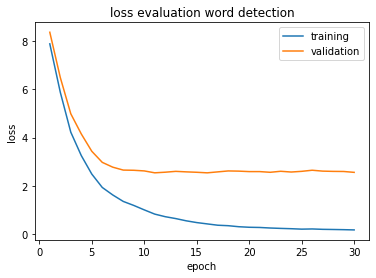

In [0]:
plt.plot([i+1 for i in range(30)], train_loss, label = "training")
plt.plot([i+1 for i in range(30)], val_loss, label= "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss evaluation word detection", fontdict = None)
plt.legend(loc = "upper right")
plt.show()

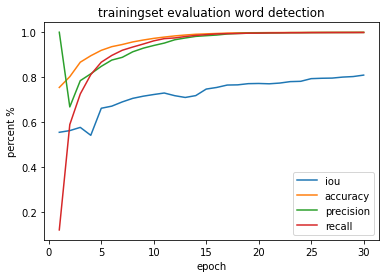

In [0]:
plt.plot([i+1 for i in range(30)], train_iou, label = "iou")
plt.plot([i+1 for i in range(30)], train_acc, label = "accuracy")
plt.plot([i+1 for i in range(30)], train_prec, label = "precision")
plt.plot([i+1 for i in range(30)], train_rec, label = "recall")
plt.xlabel("epoch")
plt.ylabel("percent %")
plt.title("trainingset evaluation word detection", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

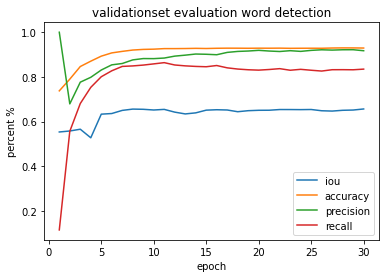

In [0]:
plt.plot([i+1 for i in range(30)], val_iou, label = "iou")
plt.plot([i+1 for i in range(30)], val_acc, label = "accuracy")
plt.plot([i+1 for i in range(30)], val_prec, label = "precision")
plt.plot([i+1 for i in range(30)], val_rec, label = "recall")
plt.xlabel("epoch")
plt.ylabel("percent %")
plt.title("validationset evaluation word detection", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

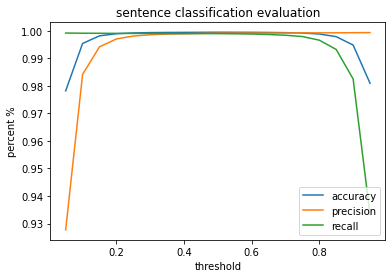

In [0]:
percents = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plt.plot(percents, train_acc, label = "accuracy")
plt.plot(percents, train_prec, label = "precision")
plt.plot(percents, train_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

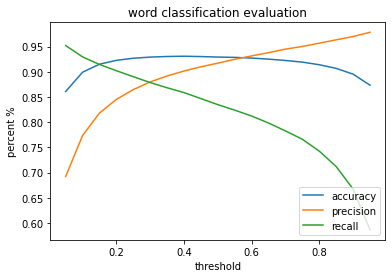

In [0]:
plt.plot(percents, val_acc, label = "accuracy")
plt.plot(percents, val_prec, label = "precision")
plt.plot(percents, val_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("word classification evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

In [0]:
weight_path = "drive/My Drive/weights_lines_to_words_30.pt"
model = torch.load(weight_path)

In [0]:
device = "cuda" 
val_list = []
train_list = []
percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#thresholds = [0.4, 0.5, 0.6]
for percent in percents:
    #for threshold in thresholds:
    print("perc", percent) #"tresh", threshold)
    val_list.append(validate(test_data, model, device, 1, percent))
    train_list.append(validate(train_data, model, device, 1, percent))

for lis in train_list:
    print(lis)

for lis in val_list:
    print(lis)

Streaming output truncated to the last 5000 lines.
loss 2.8 IOU 0.64
loss 2.5 IOU 0.68
loss 1.9 IOU 0.68
loss 2.6 IOU 0.67
loss 4.0 IOU 0.63
loss 2.5 IOU 0.64
loss 2.4 IOU 0.7
loss 2.1 IOU 0.68
loss 3.8 IOU 0.69
loss 3.1 IOU 0.65
loss 2.3 IOU 0.66
loss 2.7 IOU 0.65
loss 2.1 IOU 0.7
loss 2.5 IOU 0.71
loss 2.6 IOU 0.69
loss 2.4 IOU 0.69
loss 5.1 IOU 0.59
loss 5.3 IOU 0.65
loss 2.5 IOU 0.67
loss 3.0 IOU 0.63
loss 2.6 IOU 0.66
loss 3.6 IOU 0.62
loss 2.2 IOU 0.64
loss 2.3 IOU 0.67
loss 1.8 IOU 0.67
loss 1.2 IOU 0.71
loss 1.7 IOU 0.69
loss 2.2 IOU 0.71
loss 2.0 IOU 0.69
loss 2.0 IOU 0.65
loss 2.2 IOU 0.7
loss 1.5 IOU 0.68
loss 2.1 IOU 0.7
loss 2.9 IOU 0.69
loss 2.7 IOU 0.66
loss 1.4 IOU 0.68
loss 2.7 IOU 0.64
loss 3.0 IOU 0.67
loss 2.6 IOU 0.62
loss 3.8 IOU 0.64
loss 2.3 IOU 0.69
loss 3.1 IOU 0.68
loss 4.0 IOU 0.61
loss 2.8 IOU 0.66
loss 2.5 IOU 0.65
loss 3.4 IOU 0.68
loss 2.6 IOU 0.66
loss 2.9 IOU 0.67
loss 2.0 IOU 0.68
loss 2.7 IOU 0.63
loss 2.9 IOU 0.64
loss 3.1 IOU 0.66
loss 2.7 IOU 0.67

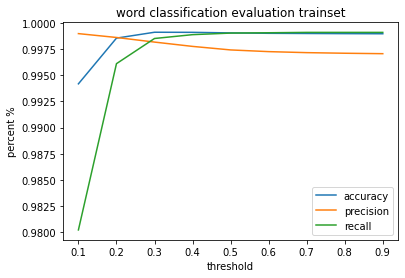

In [0]:
plt.plot(percents, train_acc, label = "accuracy") #0.1
plt.plot(percents, train_prec, label = "precision")
plt.plot(percents, train_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("word classification evaluation trainset", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

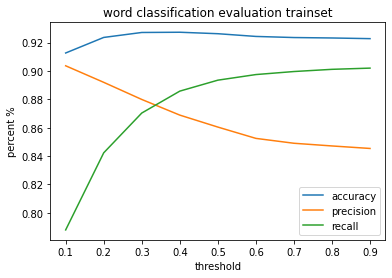

In [0]:
plt.plot(percents, val_acc, label = "accuracy") #0.1
plt.plot(percents, val_prec, label = "precision")
plt.plot(percents, val_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("word classification evaluation trainset", fontdict = None)
plt.legend(loc = "lower right")
plt.show()